## How to use DataLoader Helpers
 Classes: `WeightedDL`, `PartialDL`
 
Building Dummy examples from the [docs](https://dev.fast.ai/callback.data) where data items are just numbers 

Building Tiny-MNIST examples where the data is images + labels, and a train/valid split is inevitable. For these reasons, several variations to the dummy recipe need to be accounted for.

I think I duplicated a lot of work from here: [https://dev.fast.ai/data.transforms#End-to-end-dataset-example-with-MNIST](https://dev.fast.ai/data.transforms#End-to-end-dataset-example-with-MNIST)

In [535]:
from fastai2.vision.all import *

### Tiny-MNIST: Explore DataPath Structure

In [542]:
path = untar_data(URLs.MNIST_TINY)

In [544]:
[e for e in path.ls()]

[Path('/home/user/.fastai/data/mnist_tiny/labels.csv'),
 Path('/home/user/.fastai/data/mnist_tiny/models'),
 Path('/home/user/.fastai/data/mnist_tiny/test'),
 Path('/home/user/.fastai/data/mnist_tiny/train'),
 Path('/home/user/.fastai/data/mnist_tiny/valid')]

In [545]:
[e for e in (path/'train').ls()]

[Path('/home/user/.fastai/data/mnist_tiny/train/3'),
 Path('/home/user/.fastai/data/mnist_tiny/train/7')]

### What I usually do
Create a DataLoader right from the beginning.

Instead, we'll need to create a `Datasets` and go from that into a `WeightedDL` or a `ParitalDL`.

In [524]:
dl = ImageDataLoaders.from_folder(path,
                                  seed=0,
                                  valid_pct=0.2,
                                  num_workers=0,
                                 )

### Build a Dummy `WeightedDL`

In [496]:
n=8
made_dsets = Datasets(torch.arange(n).float())

made_wdl = made_dsets.weighted_dataloaders(wgts=range(n), bs=8)

In [497]:
for _ in range(3): print(made_wdl.one_batch())

(tensor([5., 6., 6., 7., 4., 4., 6., 6.]),)
(tensor([4., 6., 4., 6., 4., 6., 7., 7.]),)
(tensor([7., 5., 5., 5., 1., 3., 2., 6.]),)


### How to build a Tiny-MNIST `WeightedDL`
Major differences:
 - here we go to a Dataset from a DataBlock
 - dataset directory specfic logic: need to handle loading item/label
   - this can also be gotten around by specifying in datablock `splitter=GrandParentSplitter()`
 - dsets will be split with poritions of data in train vs split
   - therefore, we need to insert wgts of length equal to dsets.train.items
 - need to add on `after_item=Pipeline([ToTensor()])` to build the DataLoader so that it can run batches

In [498]:
def my_get_image_files(p):
    ''' removes /test/ directory files from returned items'''
    
    return [it for it in  get_image_files(p) 
            if parent_label(it) != 'test']

In [499]:
mnist = DataBlock(blocks = (ImageBlock(cls=PILImageBW),CategoryBlock),
                  get_items = my_get_image_files,
                  splitter = GrandparentSplitter(),
                  get_y = parent_label)

In [500]:
dsets = mnist.datasets(untar_data(URLs.MNIST_TINY), verbose=True)

Found 1408 items
2 datasets of sizes 709,699
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize


In [501]:
dsets.vocab

(#2) ['3','7']

In [502]:
len(dsets), len(dsets.train)

(1408, 709)

In [503]:
p3, p7 = 1, 6

wgts = [p3 if parent_label(e) == '3' else p7 
        for e in dsets.train.items]

print(wgts[:5], wgts[-5:])

[1, 1, 1, 1, 1] [6, 6, 6, 6, 6]


In [504]:
mnist_wdl = dsets.weighted_dataloaders(
                                #wgts=range(len(dsets.train)), 
                                wgts=wgts,
                                bs=16,
                                after_item=Pipeline([ToTensor()]),
                                )

In [546]:
mnist_wdl

In [549]:
mnist_wdl.one_batch()[1]

TensorCategory([1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1])

In [514]:
print(mnist_wdl[0].shuffle, mnist_wdl[1].shuffle)
mnist_wdl[1].one_batch()[1]

True False


TensorCategory([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

As can be seen, the batch heavily over-emphasize the 1-class (sevens) over the 0-class (threes) in training set (which is shuffled) while the validation is not shuffled and remains in order.

### Build a Dummy `PartialDL`

In [522]:
n=160
made_dsets = Datasets(torch.arange(n).float())

made_pdl = made_dsets.partial_dataloaders(partial_n=30, bs=8)

In [523]:
for b in made_pdl[0]:
    print(b)

(tensor([ 15.,  74.,  51., 158., 157., 153., 118.,  54.]),)
(tensor([150.,  37., 135.,  34.,  17., 102., 140.,  47.]),)
(tensor([ 67., 145., 125.,  91.,  72.,   8.,  28.,  11.]),)


### Build Tiny-MNIST `PartialDL`
Again, add `after_item` method to turn PILs (created from Paths) into Tensors which are valid type to do a batch with.

In [471]:
my_pdl = dsets.partial_dataloaders(
                    partial_n=64, 
                    bs=12,
                    after_item=Pipeline([ToTensor()]),
                    )

In [482]:
for e in my_pdl[0]:
    print(len(e[0]))
    

12
12
12
12
12


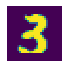

In [481]:
show_image(my_pdl.one_batch()[0][0])